In [685]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
warnings.filterwarnings("ignore")
import pickle
import wordcloud 
import spacy
import spacy.lang.pt
import string

from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from unicodedata import normalize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


''' Transforming text into something an algorithm can digest it a complicated process. We cannot feed the data 
as it is, some preprocessing needs to be done. 
In this task we will be doing some preprocessing to convert our data in a form that we can feed our model with.'

## Análise exploratória 
- Entendimento do Dataset (Checagem dos tipos de dados; formato; presença de valores nulos; presença de valores duplicados)

In [686]:
Path() / '..'/ 'data' / 'processed_utf8' / 'Data_Train_utf.xlsx'

WindowsPath('../data/processed_utf8/Data_Train_utf.xlsx')

In [687]:
df = pd.read_excel('../data/processed_utf8/Data_Train_utf.xlsx')
df.head()

,ID,Message,SPAM
0,615317,Linda msg!,True
1,855344,To fazendo batida de kwui com coco,True
2,1007222,Esse dinheiro só vai sair para quem está com o...,True
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True
4,913944,Ai xara eu sujiro esse,True


In [688]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       1773 non-null   int64 
 1   Message  1773 non-null   object
 2   SPAM     1773 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 29.6+ KB


In [689]:
df.shape

(1773, 3)

In [690]:
df.drop_duplicates(inplace=True)

In [691]:
df.isnull().sum()

ID         0
Message    0
SPAM       0
dtype: int64

Salvando uma cópia do Dataset original

In [692]:
data = df.copy()
data.head()

,ID,Message,SPAM
0,615317,Linda msg!,True
1,855344,To fazendo batida de kwui com coco,True
2,1007222,Esse dinheiro só vai sair para quem está com o...,True
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True
4,913944,Ai xara eu sujiro esse,True


## Distribuição dos dados
- Como estão distribuídos os dados
- Razão entre Spam e não-Spam

In [693]:
df['SPAM'].value_counts()

True     932
False    841
Name: SPAM, dtype: int64

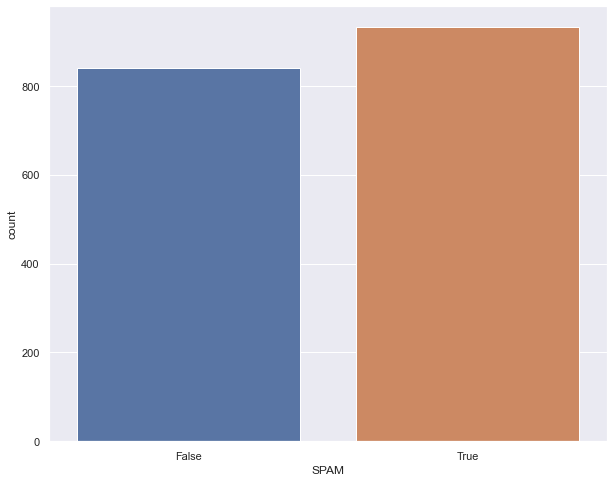

In [694]:
sns.countplot(df['SPAM'])
plt.show()

O plot mostra que o Dataset está balanceado

Convertendo a coluna 'SPAM' para forma numérica

In [695]:
df['SPAM_int'] = df['SPAM'].map({True:1, False:0})

In [696]:
df

,ID,Message,SPAM,SPAM_int
0,615317,Linda msg!,True,1
1,855344,To fazendo batida de kwui com coco,True,1
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1
4,913944,Ai xara eu sujiro esse,True,1
...,...,...,...,...
1768,521420,Meu nome e alex sandro,True,1
1769,791210,Hum\nTenho ums aki\nN\nTenhos ums piso aki\nE ...,True,1
1770,1031770,Quem tem padrinho não morre pagão\nQuem tem pa...,True,1
1771,580122,ALUNO QUE PROCESSOU PROFESSOR POR TER TOMADO C...,True,1


## Construindo a word cloud dos termos:
- Para todas as palavras do Dataset;
- Para as palavras presentes nas mensagens não SPAM;
- Para as palavras presentes nas mensagens SPAM.

*Foram adicionadas palavras extra ao conjunto pré definido

In [697]:
nltk_stopwords = stopwords.words('portuguese') + ["da", "meu", "em", "de", "ao", "os", "para", "vai", "pra"]

In [698]:
#Checagem se as palavras novas foram adicionadas corretamente
nltk_stopwords 

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

## Removendo stopwords e caracteres indesejados

As funções remove_stopwords e normalizatexto foram aplicadas para, respectivamente retirar as stopwords presentes no texto, e remover caracteres indesejados.

In [699]:
def remove_stopwords(texto):
    
    novo_texto = []
    tokens = nltk.word_tokenize(texto)
    for token in tokens:
        if len(token) > 2 and token not in nltk_stopwords:
            novo_texto.append(token)
    output = ' '.join(novo_texto)
    return output

In [700]:
def normalizaTexto(texto):    
    output = re.sub(r'[-.;?!:,"()\'_x000d_]','', texto)
    output = remove_stopwords(output)
    output = normalize('NFKD', output).encode('ASCII', 'ignore').decode('ASCII')
    return output.lower()

In [701]:
#Simples checagem se a função 'normalizatexto' funcionou, observando a primeira linha do Dataset
texto = df['Message'].iloc[0]

In [702]:
normalizaTexto(texto)

'lina msg'

In [703]:
#Aplicação da função 'normalizatexto' na coluna 'Message'
df['text_norm'] = df['Message'].apply(normalizaTexto)

In [704]:
df

,ID,Message,SPAM,SPAM_int,text_norm
0,615317,Linda msg!,True,1,lina msg
1,855344,To fazendo batida de kwui com coco,True,1,fazeno batia kwui coco
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse inheiro sair nome lista esse inheiro sair...
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk
4,913944,Ai xara eu sujiro esse,True,1,ara sujiro
...,...,...,...,...,...
1768,521420,Meu nome e alex sandro,True,1,meu nome ale sanro
1769,791210,Hum\nTenho ums aki\nN\nTenhos ums piso aki\nE ...,True,1,hum tenho ums aki tenhos ums piso aki ivisoria
1770,1031770,Quem tem padrinho não morre pagão\nQuem tem pa...,True,1,quem parinho morre pagao quem parinho morre pa...
1771,580122,ALUNO QUE PROCESSOU PROFESSOR POR TER TOMADO C...,True,1,aluno que processou professor por ter tomado c...


A junção de todas as mensagens em 'text_norm' forma um grande texto sem quebras, onde será gerada a primeira wordcloud, sem distinção de SPAM e não SPAM.

In [705]:
big_text = ' '.join(text for text in df['text_norm'])

In [706]:
big_text[:100]

'lina msg fazeno batia kwui coco esse inheiro sair nome lista esse inheiro sair nome lista isso msm i'

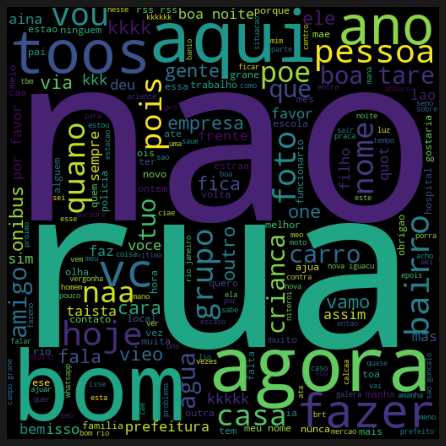

In [707]:
#Word cloud com todas as palavras
big_text_cloud = WordCloud(width = 512, height = 512).generate(big_text)

plt.figure(figsize = (7,6), facecolor = 'k')
plt.imshow(big_text_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

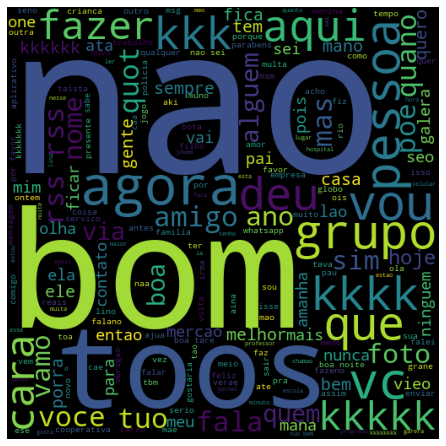

In [708]:
#Não SPAM

no_spam_words = ' '.join(df[df['SPAM'] == True ]['text_norm'])
no_spam = WordCloud(width = 512, height = 512).generate(no_spam_words)

plt.figure(figsize = (7,6), facecolor = 'w')
plt.imshow(no_spam)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

A nuvem de palavras mostra que um caractere _x000d_ ocorre de forma frequente, este representa um caractere de linha '\n' que foi gerando quando o arquivo foi salvo no formato utf8. Então, este argumento serár etirado do texto.

In [709]:
#df['text_norm'] = df['Message'].apply(remove_x000d_)
#df['Message'] = df['Message'].apply(remove_x000d_)

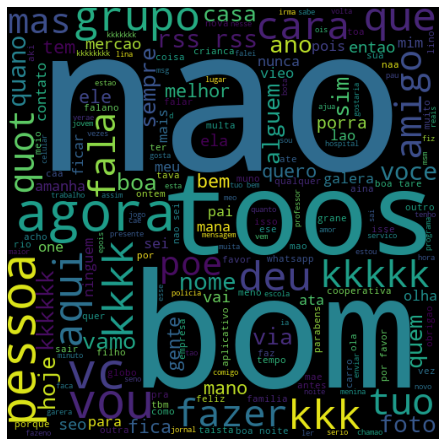

In [710]:

no_spam_words = ' '.join(df[df['SPAM'] == True ]['text_norm'])
no_spam = WordCloud(width = 512, height = 512).generate(no_spam_words)

plt.figure(figsize = (7,6), facecolor = 'w')
plt.imshow(no_spam)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

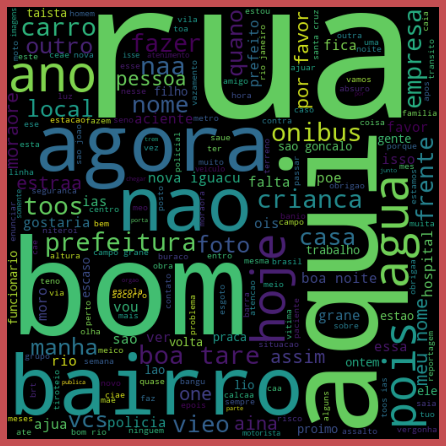

In [711]:
#SPAM

spam_words = ' '.join(df[df['SPAM'] == False ]['text_norm'])
spam_wc = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize = (7,6), facecolor = 'r')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Tokenization

A tokenização irá o texto em pequenos pedaços. A tokenização quebra o texto em palavras, frases chamadas tokens. Esses tokens ajudam a entender o contexto ou desenvolver o modelo para a PNL. A tokenização ajuda na interpretação do significado do texto, analisando a sequência das palavras.

In [712]:
#Aplicando a função para Tokenização
def tokenize(text):
    tokens = re.split("\W+", text)# W+ - Qualquer caractere de palavra 0-9 a-z A-Z
    return tokens

df["text_tokenized"] = df["text_norm"].apply(tokenize)

df.head()

,ID,Message,SPAM,SPAM_int,text_norm,text_tokenized
0,615317,Linda msg!,True,1,lina msg,"[lina, msg]"
1,855344,To fazendo batida de kwui com coco,True,1,fazeno batia kwui coco,"[fazeno, batia, kwui, coco]"
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse inheiro sair nome lista esse inheiro sair...,"[esse, inheiro, sair, nome, lista, esse, inhei..."
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk,"[isso, msm, irma, nao, lembrava, nomes, kkk]"
4,913944,Ai xara eu sujiro esse,True,1,ara sujiro,"[ara, sujiro]"


## Lemmatizer

Na lemmatization se busca reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao 'lemma'. Porém, essa redução sempre resultará em uma palavra que realmente existe na gramática. Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução.

In [713]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(t_text):
    text = [wn.lemmatize(word) for word in t_text]
    return text

df["text_lemmatized"] = df["text_tokenized"].apply(lemmatizer)
df.head()

,ID,Message,SPAM,SPAM_int,text_norm,text_tokenized,text_lemmatized
0,615317,Linda msg!,True,1,lina msg,"[lina, msg]","[lina, msg]"
1,855344,To fazendo batida de kwui com coco,True,1,fazeno batia kwui coco,"[fazeno, batia, kwui, coco]","[fazeno, batia, kwui, coco]"
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse inheiro sair nome lista esse inheiro sair...,"[esse, inheiro, sair, nome, lista, esse, inhei...","[esse, inheiro, sair, nome, lista, esse, inhei..."
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk,"[isso, msm, irma, nao, lembrava, nomes, kkk]","[isso, msm, irma, nao, lembrava, nome, kkk]"
4,913944,Ai xara eu sujiro esse,True,1,ara sujiro,"[ara, sujiro]","[ara, sujiro]"


## Analisando o tamanho das msengaens e percentagem de pontos.
- Em busca de diferenciar SPAM e não SPAM, serão aplicadas técnicas que agrupam mensagens SPAM e não SPAM, observando se há diferença de comportamento para cada tipo de mensagem em relação ao seu tamanho e frequência de pontuação. 

In [714]:
# Function to calculate length of message excluding space
df['Message_len'] = df['Message'].apply(lambda x: len(x) - x.count(" "))

df.head()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['punct%'] = df['Message'].apply(count_punct)

df.head()

,ID,Message,SPAM,SPAM_int,text_norm,text_tokenized,text_lemmatized,Message_len,punct%
0,615317,Linda msg!,True,1,lina msg,"[lina, msg]","[lina, msg]",9,11.1
1,855344,To fazendo batida de kwui com coco,True,1,fazeno batia kwui coco,"[fazeno, batia, kwui, coco]","[fazeno, batia, kwui, coco]",28,0.0
2,1007222,Esse dinheiro só vai sair para quem está com o...,True,1,esse inheiro sair nome lista esse inheiro sair...,"[esse, inheiro, sair, nome, lista, esse, inhei...","[esse, inheiro, sair, nome, lista, esse, inhei...",113,7.1
3,811063,Isso msm Irmã.. nao lembrava dos nomes kkk,True,1,isso msm irma nao lembrava nomes kkk,"[isso, msm, irma, nao, lembrava, nomes, kkk]","[isso, msm, irma, nao, lembrava, nome, kkk]",35,5.7
4,913944,Ai xara eu sujiro esse,True,1,ara sujiro,"[ara, sujiro]","[ara, sujiro]",18,0.0


In [715]:
df['SPAM'].value_counts()

True     932
False    841
Name: SPAM, dtype: int64

Avaliando distribuição dos tamanhos das palavras e presença de pontuação em Spam e não Spam

In [716]:
df.groupby('SPAM')['Message_len'].sum()

SPAM
False    135142
True     136054
Name: Message_len, dtype: int64

In [717]:
df.groupby('SPAM')['punct%'].sum()

SPAM
False    2353.9
True     2813.7
Name: punct%, dtype: float64

Para facilitar a visualização da distribuição individual para p número de caracteres e pontuação, dois histogramas serão utilizados.

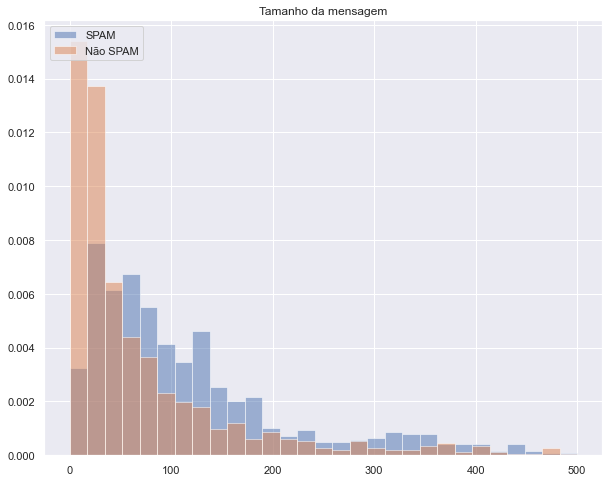

In [718]:
sns.set(rc= {"figure.figsize": (10, 8)})

bins = np.linspace(0, 500, 30)

plt.hist(df[df['SPAM_int']==0]['Message_len'], bins, alpha=0.5, density=True, label='SPAM')
plt.hist(df[df['SPAM_int']==1]['Message_len'], bins, alpha=0.5, density=True, label='Não SPAM')
plt.legend(loc='upper left')
plt.title('Tamanho da mensagem')
plt.show()

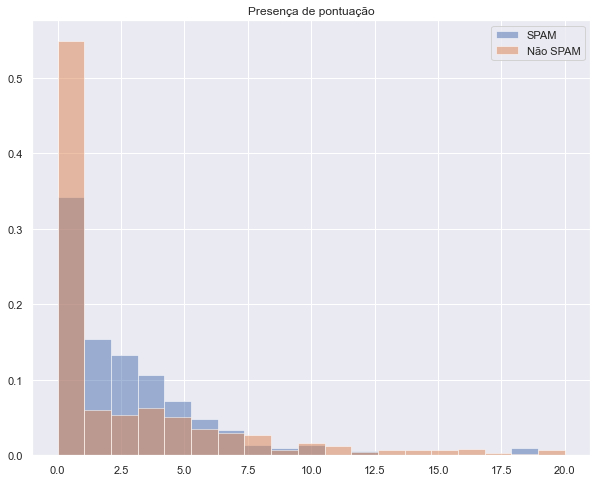

In [719]:
sns.set(rc= {"figure.figsize": (10, 8)})

bins = np.linspace(0, 20, 20)

plt.hist(df[df['SPAM_int']==0]['punct%'], bins, alpha=0.5, density=True, label='SPAM')
plt.hist(df[df['SPAM_int']==1]['punct%'], bins, alpha=0.5, density=True, label='Não SPAM')
plt.legend(loc='upper right')
plt.title('Presença de pontuação')
plt.show()

### Analisando as palavras mais frequentes para Spam e não Spam

In [720]:
count1 = Counter(" ".join(df[df['SPAM_int']==1]["text_norm"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(df[df['SPAM_int']==0]["text_norm"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

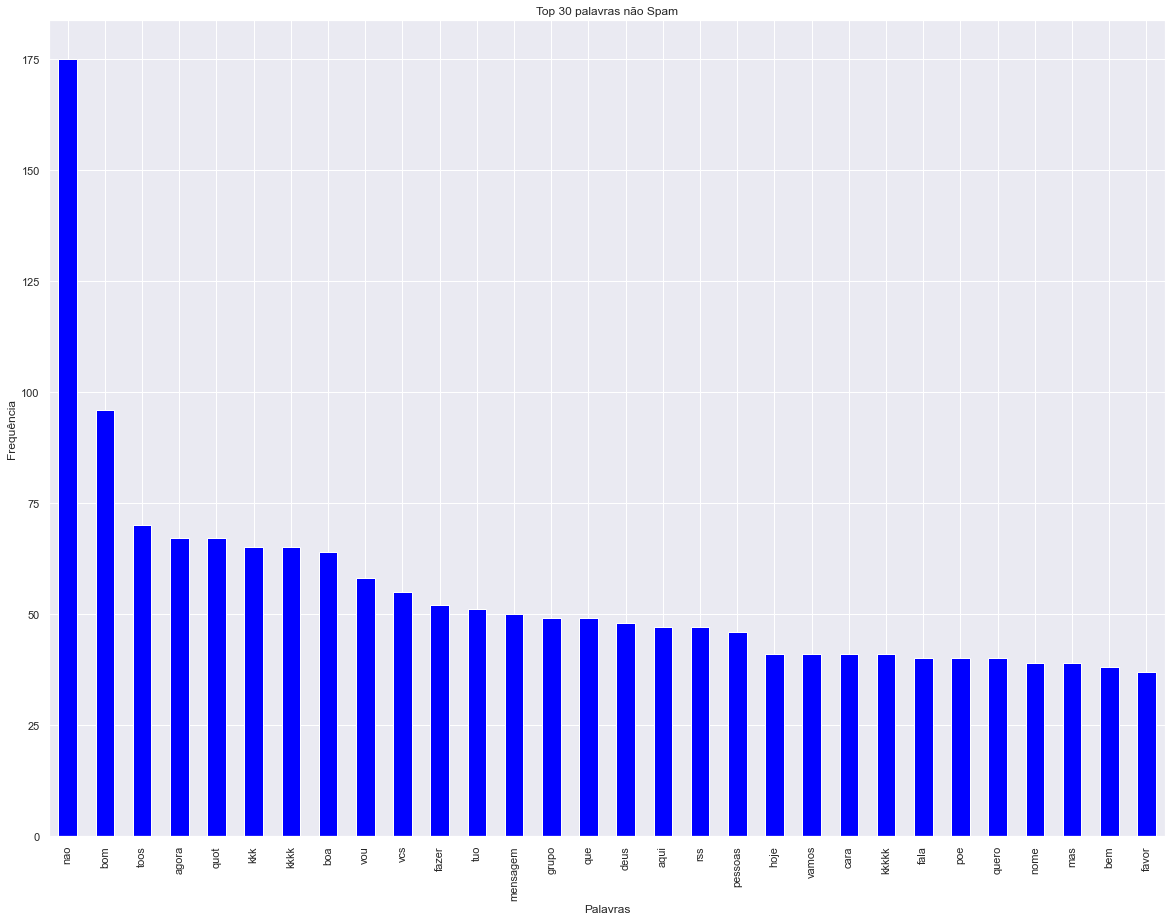

In [721]:
data1.plot.bar(legend = False, color = 'blue',figsize = (20,15))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 30 palavras não Spam')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.show()

As palavras mais comuns em textos não SPAM mostram a informalidade das mensagens. Se destaca como palavra mais comum em mensagens não SPAM 'xd000_'. Possivelmente é um erro gerado por emoticons ou imagens em mensagens. Esta característica é marcante em mensagens não SPAM.

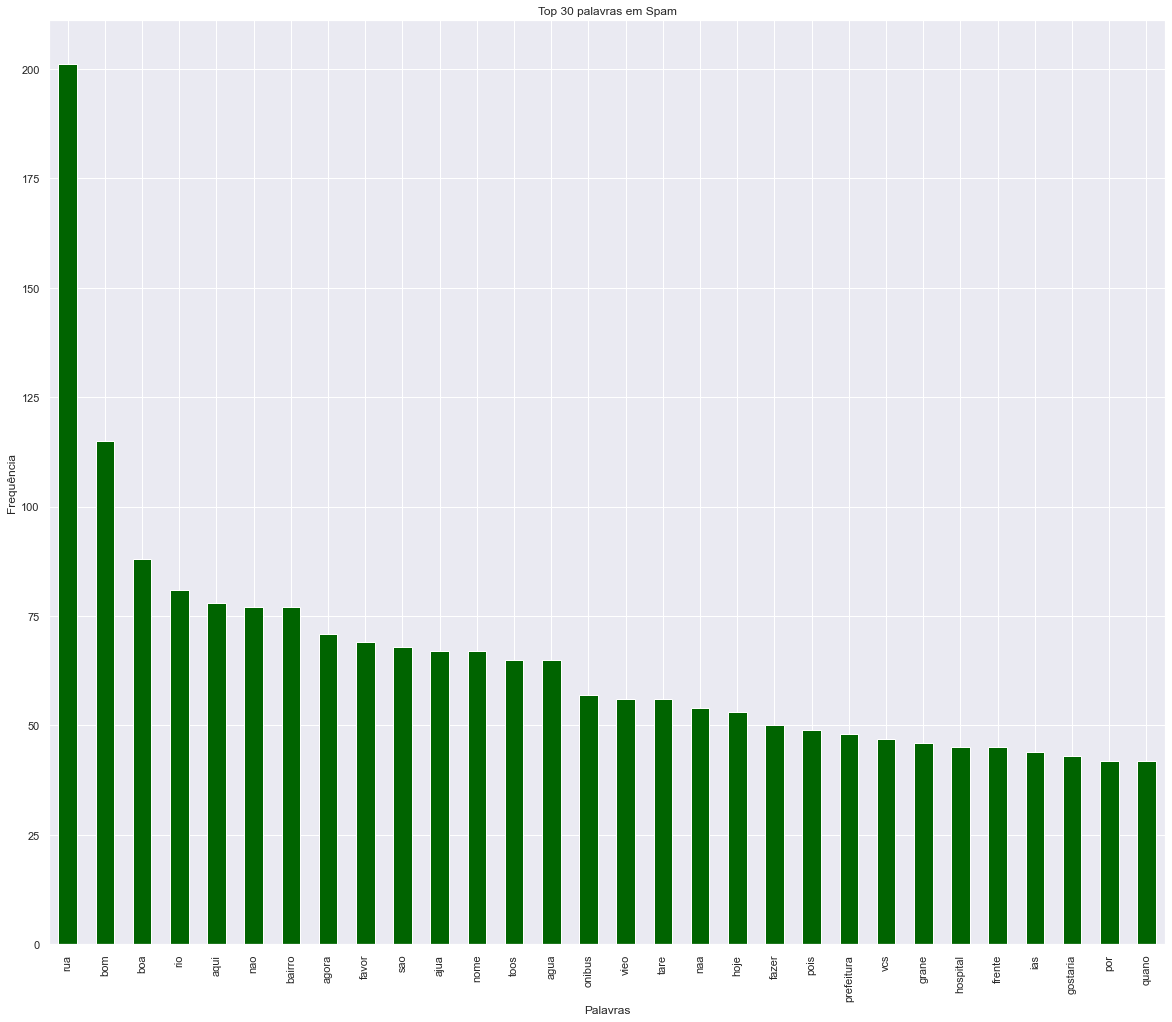

In [722]:
data2.plot.bar(legend = False, color = 'darkgreen', figsize = (20,17))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 30 palavras em Spam')
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.show()

In [752]:
df.to_pickle('C:\\Users\\Thiag\\spam_ham\\data\\dataframe_to_modeling\\spam_ham.pickle')

Como esperado, texto de mansagens SPAM contêm em destaque palavras como 'Rua' (possível endereço para encontrar o serviço oferecido), 'bom' e 'dia', que representam saudações recorrentes nesses tipos de mensagens.

## Vetorização
É importante a criação de um CountVectorizer para contar o número de palavras (frequência do termo), 
limitar o tamanho do seu vocabulário e, aplicar palavras de parada, por exemplo.

## Bag of words
A criação da 'Bag of words' se dá na necessidade de converter cada uma dessas mensagens (lemmas) em um vetor que os modelos de algoritmos do SciKit Learn possam trabalhar.

### Passos:

Contar quantas vezes uma palavra ocorre em cada mensagem (conhecida como frequência de termo) pelo CountVectorizer;

Pesar as contagens, para que os tokens frequentes tenham um peso menor (frequência inversa do documento);

Normalizar os vetores para comprimento unitário, para abstrair do comprimento do texto original (norma L2) por TF-IDF, usando o TfidfTransformer do scikit-learn.

CountVectorizer : converterá uma coleção de documentos de texto em uma matriz de contagens de token em matriz 2D:

In [723]:
cv = CountVectorizer()#analizer = função pra limpar o texto
word_count_vector = cv.fit_transform(df['text_norm'])

In [741]:
df.isnull().sum()

ID                 0
Message            0
SPAM               0
SPAM_int           0
text_norm          0
text_tokenized     0
text_lemmatized    0
Message_len        0
punct%             0
dtype: int64

In [724]:
#aqui as colunas reprensentam palavras únicas (9411)
word_count_vector.shape

(1773, 9307)

## Aplicando TFIDF 
Codificação de texto como inteiro em forma numérica para criar vetores de recursos para que possamos aplicar algoritmos de ML nele.

In [725]:
feature_extraction = TfidfVectorizer(min_df=1, lowercase = 'True')
# min_df = se uma palavra não repetir, ou repetir apenas uma vez, ela não é importante para análises predivitas.

In [ ]:
X_tfidf = feature_extraction.fit_transform(df['text_norm'])
print(X_tfidf.shape)
print(feature_extraction.get_feature_names())

## Modeling

In [727]:
import pandas as pd
import re
import string
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


## Modelagem
Nesta etapa diversos modelos de ML serão utilizados visando encontrar os melhores modelos para classificação de mensagens SPAM ou não SPAM.

Serão aplicados os seguintes modelos: 
            LogisticRegression
            MultinomialNB
            KNeighborsClassifier
            SVC
            DecisionTreeClassifier
            RandomForestClassifier
            GradientBoostingClassifier
            AdaBoostClassifier

Separando o Dataset em treino e teste

In [728]:
X=df[['Message', 'Message_len', 'punct%']]
y=df['SPAM']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

In [729]:
#feature_extraction = TfidfVectorizer(min_df=1, lowercase = 'True')

feature_extraction_fit = feature_extraction.fit(X_train['Message']) #Message ou Message

tfidf_train = feature_extraction_fit.transform(X_train['Message'])
tfidf_test = feature_extraction_fit.transform(X_test['Message'])

X_train_vect = pd.concat([X_train[['Message_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Message_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,Message_len,punct%,0,1,2,3,4,5,6,7,...,7757,7758,7759,7760,7761,7762,7763,7764,7765,7766
0,100,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,107,9.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,294,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.159563,0.0,0.0,0.0


Aplicação do modelos

In [730]:
lr = LogisticRegression()
nb = MultinomialNB()
knc = KNeighborsClassifier()
svc = SVC(gamma = 'auto')
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_estimators=100)
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()



models = {'Logistic Regression':lr, 'Naive Bayes classifier':nb, 'k-nearest neighbors':knc, 
          'Support Vector Machine':svc, 'Decision Tree Classifier':dtc, 
          'Random Forest Classifier':rfc, 'Gradient Boosting Classifier':gbc, 'AdaBoost Classifier':abc}

In [754]:
def eval_model(model):
    
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['ham', 'spam'], index=['ham','spam'])
    
    return test_accuracy, conf_matrix

In [756]:
test_accuracies = []

for name, model in models.items():
    test_acc, conf_matrix = eval_model(model) 
    test_accuracies.append(test_acc)
    print(f'{name} ---> Test accuracy - {test_acc*100:.2f}%')

TypeError: cannot unpack non-iterable numpy.float64 object

## Melhorando hiperparametros com Grid Search

Grid search para Random Forest


In [494]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [499]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(tfidf_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [500]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

Grid Search para Logistic Regression


In [501]:
parameter_grid = {'C':[0.001,0.01,0.1,1,10], 
                  'penalty':['l1', 'l2']  
                  }

In [502]:
estimator = GridSearchCV(estimator=lr, param_grid=parameter_grid, \
scoring='accuracy', cv=10, n_jobs=-1)

In [504]:
estimator.fit(tfidf_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [505]:
print(estimator.best_params_)
print(estimator.best_estimator_)
print(estimator.best_score_)

{'C': 10, 'penalty': 'l2'}
LogisticRegression(C=10)
0.8630000000000001


## Naive Bayes Grid Search
# CONTINUAR PESQUISANDO GRID SEARCH PARA Multinomial NB


In [507]:
from sklearn.pipeline import Pipeline

In [515]:
classifier = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('nb', MultinomialNB()),
])

# parameter tuning with grid search
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
              'vect__max_df': ( 0.7,0.8,0.9,1.0),
              'vect__min_df': (1,2),    
              'nb__alpha': ( 0.022,0.025, 0.028),
}
gs_clf = GridSearchCV(classifier, parameters,n_jobs=-1, verbose=1,cv=5)
gs_clf.fit(tfidf_train, y_train)
best_parameters = gs_clf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


ValueError: 
All the 360 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\pipeline.py", line 870, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\feature_extraction\text.py", line 1338, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\feature_extraction\text.py", line 1209, in _count_vocab
    for feature in analyze(doc):
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\feature_extraction\text.py", line 111, in _analyze
    doc = preprocessor(doc)
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\sklearn\feature_extraction\text.py", line 69, in _preprocess
    doc = doc.lower()
  File "c:\Users\Thiag\spam_ham\.spam_ham\lib\site-packages\scipy\sparse\_base.py", line 771, in __getattr__
    raise AttributeError(attr + " not found")
AttributeError: lower not found


## Avaliação de precisão do modelo

- Precisão: qual a proporção dos dados classificados como SPAM eram realmente SPAM. (falsos positivos)

- Recall: entre todas as amostras que realmente eram de SPAM, qual a proporção classificada como SPAM. (falsos negativos)

- F1-score: uma maneira de observar em um único número a precisão e o recall.


In [482]:
lr_model = lr.fit(X_train_vect, y_train)

y_pred = lr_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=False, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.835 / Recall: 0.821 / F1-Score: 0.828


In [483]:
lr_model = lr.fit(X_train_vect, y_train)

y_pred = lr_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=True, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848


In [491]:
#tentar criar um laço para fornecer Precision, Recall e 1=F1-Score para os modelos

test_accuracies = []

for name, model in models.items():
    test_acc, conf_matrix = eval_model(model) 
    test_accuracies.append(precision)
    lr_model = lr.fit(X_train_vect, y_train)
    y_pred = lr_model.predict(X_test_vect)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=True, average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {}'.format(
round(precision, 3), round(recall, 3), round(fscore,3)))

Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848
Precision: 0.842 / Recall: 0.854 / F1-Score: 0.848


In [ ]:
scores = cross_val_score(classifier, counts, classes, cv=5)

# Print the accuracy of each fold:
print(scores)

# Print the mean accuracy of all 5 folds
print(scores.mean())

11:30 - 12h -  Naive Bayes Grid search/usar só o naive bayes?

10:30 - 11:30min - Dados em csv e compilar os modelos na pasta modeling

20 min - Rodar arquivo de teste

OK - 10 - 10:30min - Tratar o _xd000_

O uniformizar o kkkk???


